# Assignment 2
The objective of this assignment is to get you familiarizewith  the  problems  of  `classification`  and  `verification`with a popular problem space of `face`

This jupyter notebook is meant to be used in conjunction with the full questions in the assignment pdf.

## Instructions
- Write your code and analyses in the indicated cells.
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Do not attempt to change the contents of the other cells.

## Allowed Libraries
- All libraries are allowed 

## Datasets 
- 3 datasets are provided. Load the data from the drive [link](!https://drive.google.com/file/d/1ujsKv9W5eidb4TXt1pnsqwDKVDFtzZTh/view?usp=sharing).
- Unzip the downloaded file and store the files in a folder called `datasets`. Keep the `datasets` folder in the same directory as of the jupyter notebook 

## Submission
- Ensure that this notebook runs without errors when the cells are run in sequence.
- Rename the notebook to `<roll_number>.ipynb` and submit ONLY the notebook file on moodle.
- Upload  the  notebook,  report  and  classification  results as a zip file to moodle. Name the zip file as `<rollnumber>_assignment2.zip`

In [1]:
# Installing Libraries
# !pip3 install scikit-learn matplotlib Pillow

In [2]:
# Basic Imports
import os
import sys
import random
import warnings
import numpy as  np
import pandas as pd
from scipy import linalg
import warnings


# Loading and plotting data
from PIL import Image
import matplotlib.pyplot as plt 
from mpl_toolkits.mplot3d import Axes3D

# Features
from sklearn.decomposition import PCA 
from sklearn.decomposition import KernelPCA
from sklearn.discriminant_analysis import _class_means,_class_cov
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis as LDA
from sklearn.manifold import TSNE
from collections import defaultdict

# Model Imports
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.model_selection import KFold
from sklearn.neighbors import KNeighborsClassifier

# Metrics Import
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, classification_report, confusion_matrix

# Split Import
from sklearn.model_selection import train_test_split

plt.ion()
warnings.filterwarnings("ignore")
%matplotlib inline

# Parameters
- Image size: Bigger images create better representation but would require more computation. Choose the correct image size based on your Laptop configuration. 
- is_grayscale: Should you take grayscale images? Or rgb images? Choose whichever gives better representation for classification. 

In [3]:
opt = {
    'image_size': 32,
    'is_grayscale': False,
    'val_split': 0.75
}

### Load Dataset

In [4]:
cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 1,
    'DwayneJohnson': 2,
    'AishwaryaRai': 3,
    'BarackObama': 4,
    'NarendraModi': 5,
    'ManmohanSingh': 6,
    'VladimirPutin': 7}

imfdb_dict = {'MadhuriDixit': 0,
     'Kajol': 1,
     'SharukhKhan': 2,
     'ShilpaShetty': 3,
     'AmitabhBachan': 4,
     'KatrinaKaif': 5,
     'AkshayKumar': 6,
     'Amir': 7}

# Load Image using PIL for dataset
def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "yale" in dir_path.lower():
        label_dict = {}
        for i in range(15):
            label_dict[str(i+1)] = i
    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list,y_list

# Display N Images in a nice format
def disply_images(imgs,classes,row=1,col=2,w=64,h=64):
    fig=plt.figure(figsize=(8, 8))
    for i in range(1, col*row +1):
        img = imgs[i-1]
        fig.add_subplot(row, col, i)
        
        if opt['is_grayscale']:
            plt.imshow(img , cmap='gray') 
        else:
            plt.imshow(img)
        
        plt.title("Class:{}".format(classes[i-1]))
        plt.axis('off')
    plt.show()

Dataset shape: (400, 32, 32, 3)
Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


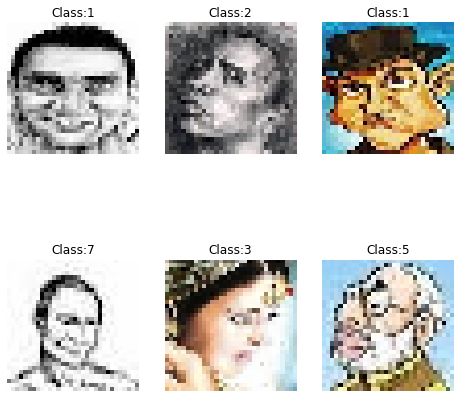

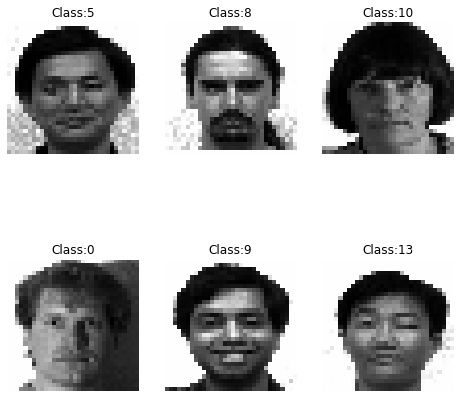

In [5]:
# Loading the dataset
# eg.

def read_data(dirpath):
    X, y = load_data(dirpath)
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    
    return X, y, N, H, W, C

dirpath = './dataset/IMFDB/'
X, y, N, H, W, C = read_data(dirpath)

dirpath_imfdb = './dataset/IMFDB/'
X_imfdb, y_imfdb, N_imfdb, H_imfdb, W_imfdb, C_imfdb = read_data(dirpath_imfdb)

# print(y_imfdb)

dirpath_iiit = './dataset/IIIT-CFW/'
X_iiit, y_iiit, N_iiit, H_iiit, W_iiit, C_iiit = read_data(dirpath_iiit)

dirpath_yale = './dataset/Yale_face_database/'
X_yale, y_yale, N_yale, H_yale, W_yale, C_yale = read_data(dirpath_yale)

ind = np.random.randint(0,y_iiit.shape[0],6)
disply_images(X_iiit[ind,...],y_iiit[ind], row=2,col=3)

ind = np.random.randint(0,y_yale.shape[0],6)
disply_images(X_yale[ind,...],y_yale[ind], row=2,col=3)

X_imfdb = X_imfdb.reshape((N_imfdb, H_imfdb * W_imfdb * C_imfdb))
X_iiit = X_iiit.reshape((N_iiit, H_iiit * W_iiit * C_iiit))
X_yale = X_yale.reshape((N_yale, H_yale * W_yale * C_yale))

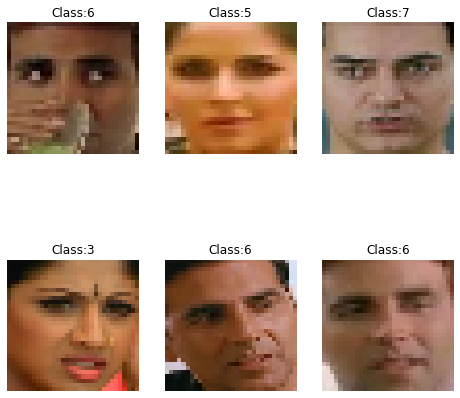

In [6]:
# Show sample images
ind = np.random.randint(0,y.shape[0],6)
disply_images(X[ind,...],y[ind], row=2,col=3)

# Features
    You are provided 6 Features. These features are:
   - Eigen Faces / PCA 
   - Kernel PCA
   - Fisher Face / LDA
   - Kernel Fisher Face
   - VGG Features 
   - Resnet Features

**VGG and Resnet features are last layer features learned by training a model for image classification**
    
---


In [7]:
# Flatten to apply PCA/LDA
X = X.reshape((N,H*W*C))

###  1. Eigen Face:
Use principal component analysis to get the eigen faces. 
Go through the [documentation](!http://scikit-learn.org/stable/modules/generated/sklearn.decomposition.PCA.html) on how to use it

In [8]:
def get_pca(X,k):
    """
        Get PCA of K dimension using the top eigen vectors 
    """
    pca = PCA(n_components=k)
    X_k = pca.fit_transform(X)
    X_r = pca.inverse_transform(X_k)
    return X_k, X_r

###  2. Kernel Face:
Use Kernel principal component analysis to get the eigen faces. 

There are different kernels that can be used. Eg. Poly, rbf, sigmoid. Choose the whichever gives the best result or representation. See [link](!https://data-flair.training/blogs/svm-kernel-functions/) for better understanding of these kernels  

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.decomposition.KernelPCA.html#sklearn.decomposition.KernelPCA) on how to use it different kernels in Sklearn. 

In [9]:
def get_kernel_pca(X, k,kernel='rbf', degree=3):
    """
        Get PCA of K dimension using the top eigen vectors 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use (“linear” | “poly” | “rbf” | “sigmoid” | “cosine” )
        @param: d => Degree for poly kernels. Ignored by other kernels
    """
    kpca = KernelPCA(n_components=k,kernel=kernel,degree=degree)
    X_k = kpca.fit_transform(X)
    return X_k

### 3. Fisher Face
Another method similar to the eigenface technique is `fisherfaces` which uses linear discriminant analysis.
This method for facial recognition is less sensitive to variation in lighting and pose of the face than using eigenfaces. Fisherface uses labelled data to retain more of the class-specific information during the dimension reduction stage.

Go through the [documentation](!https://scikit-learn.org/stable/modules/generated/sklearn.discriminant_analysis.LinearDiscriminantAnalysis.html) on how to use it different kernels in Sklearn. 

In [10]:
def get_lda(X,y,k):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
    """
#     print(k)
    lda = LDA(n_components=k)
    X_k = lda.fit_transform(X,y)
    return X_k

### 4. Kernel Fisher Face
Use LDA using different kernels similiar to KernelPCA. Here the input is directly transformed instead of using the kernel trick.  

In [11]:
def get_kernel_lda(X,y,k,kernel='rbf',degree=3):
    """
        Get LDA of K dimension 
        @param: X => Your data flattened to D dimension
        @param: k => Number of components
        @param: kernel => which kernel to use ( “poly” | “rbf” | “sigmoid”)
    """
    # Transform  input
    if kernel == "poly":
        X_transformed = X**degree
    elif kernel == "rbf":
        var = np.var(X)
        X_transformed= np.exp(-X/(2*var))
    elif kernel == "sigmoid":
        X_transformed = np.tanh(X)
    else: 
        raise NotImplementedError("Kernel {} Not defined".format(kernel))
        
    klda = LDA(n_components=k)
    X_k = klda.fit_transform(X,y)
    return X_k

### 5. VGG Features
VGG Neural Networks a 19 layer CNN architecture introduced by Andrew Zisserman([Link](!https://arxiv.org/pdf/1409.1556.pdf) to paper). We are providing you with the last fully connected layer of this model.

The model was trained for face classification on each dataset and each feature the dimension of 4096.

In [12]:
def get_vgg_features(dirpath):
    features = np.load(os.path.join(dirpath,"VGG19_features.npy"))
    return features

### 6. Resnet Features

[Residual neural networks](!https://arxiv.org/pdf/1512.03385.pdf) are CNN with large depth, to effectively train these netwrorks they utilize skip connections, or short-cuts to jump over some layers. This helps solving [vanishing gradient problem](!https://en.wikipedia.org/wiki/Vanishing_gradient_problem) 

A 50 layer resnet model was trained for face classification on each dataset. Each feature the dimension of 2048

In [13]:
def get_resnet_features(dirpath):
    features = np.load(os.path.join(dirpath,"resnet50_features.npy"))
    return features

# Questions

1(a). What are eigen faces? 

___________________________

Representation of all the face images in a dataset as linear combination of the most prominent eigenvectors (higher eigenvalue signifies more prominence) of the covariance matrix of the data matrix is known as eigenface technique. 
We try to represent all the data samples with the help of a few eigenfaces.
Example :- Sample face X would be 10% Eigenface A, 13.8 % Eigenface B, and so on, while someone else’s face would have a different combination of those same eigenfaces.


1(b).  How many eigen vec-tors/faces are required to “satisfactorily” reconstruct a  person  in  these  three  datasets? (Don’t  forget  to make your argument based on eigen value spectrum) Show appropriate graphs, qualitative examples andmake a convincing argument.

In [14]:
# Compute your features 
# eg.
X_imfdb_3D_pca, _ = get_pca(X_imfdb, 3)
X_iiit_3D_pca, _ = get_pca(X_iiit, 3)
X_yale_3D_pca, _ = get_pca(X_yale, 3)


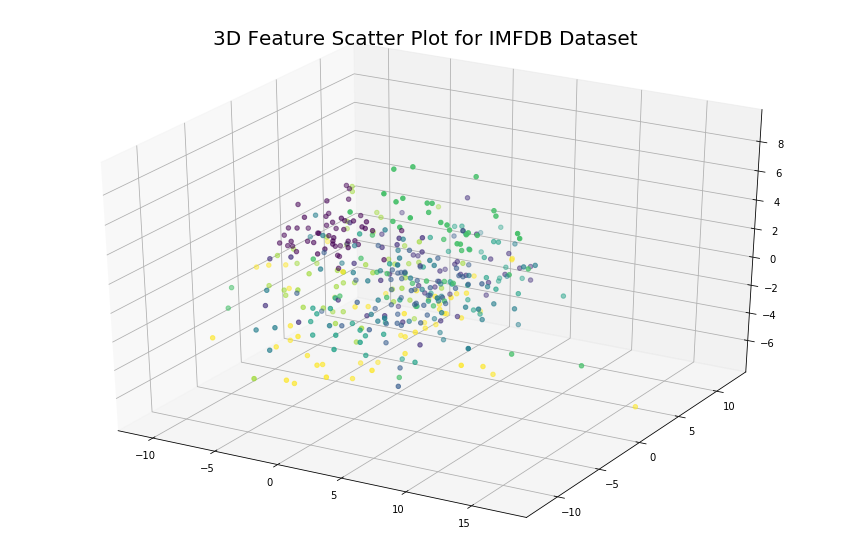

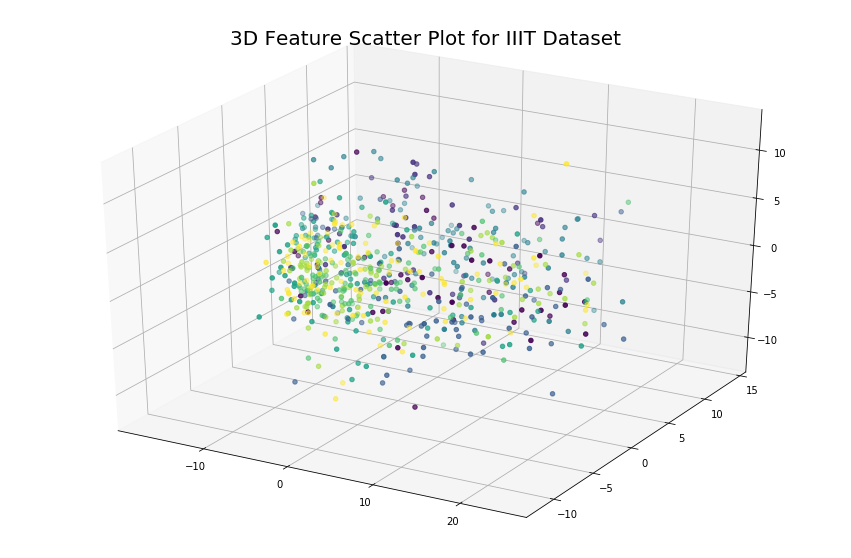

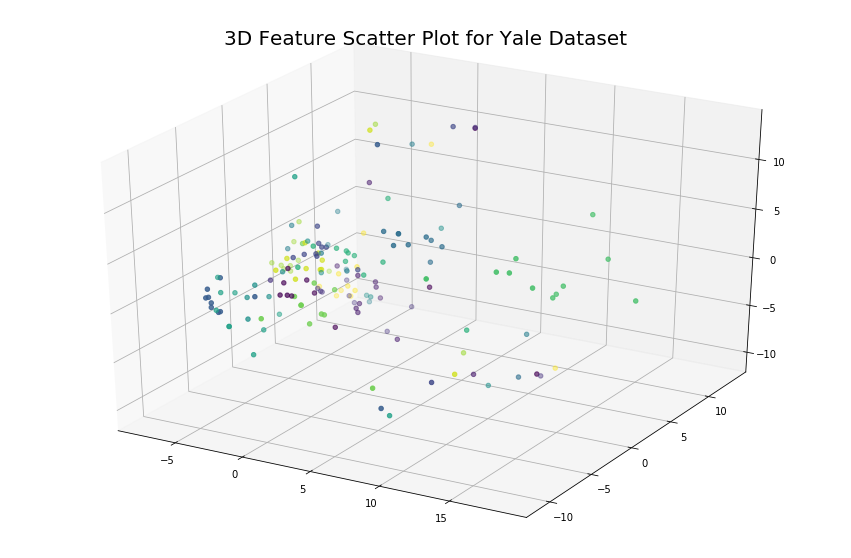

In [15]:
# Create a scatter plot  
# eg.

def plot_scatter(X_3D, y, title):
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(X_3D[:,0], X_3D[:,1], X_3D[:,2], c=y)
    ax.set_title(title, fontsize=20)
    
    plt.show()

plot_scatter(X_imfdb_3D_pca, y_imfdb, '3D Feature Scatter Plot for IMFDB Dataset')
plot_scatter(X_iiit_3D_pca, y_iiit, '3D Feature Scatter Plot for IIIT Dataset')
plot_scatter(X_yale_3D_pca, y_yale, '3D Feature Scatter Plot for Yale Dataset')


In [16]:
# Plot the eigen value spectrum 

def get_eigen(X):
    cov_mat = np.cov(X.T)
    w, v= np.linalg.eig(cov_mat)
    mean_eigv = np.mean(w)
    w /= mean_eigv
    
    return w

def plot_eigen(w, title):
    x = range(0, 100)
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    for i in range(100):
        ax.plot([x[i], x[i]], [0, w[i]])
    ax.set_title(title, fontsize=20)
    plt.show()

w_imfdb = get_eigen(X_imfdb)
w_iiit = get_eigen(X_iiit)
w_yale = get_eigen(X_yale)

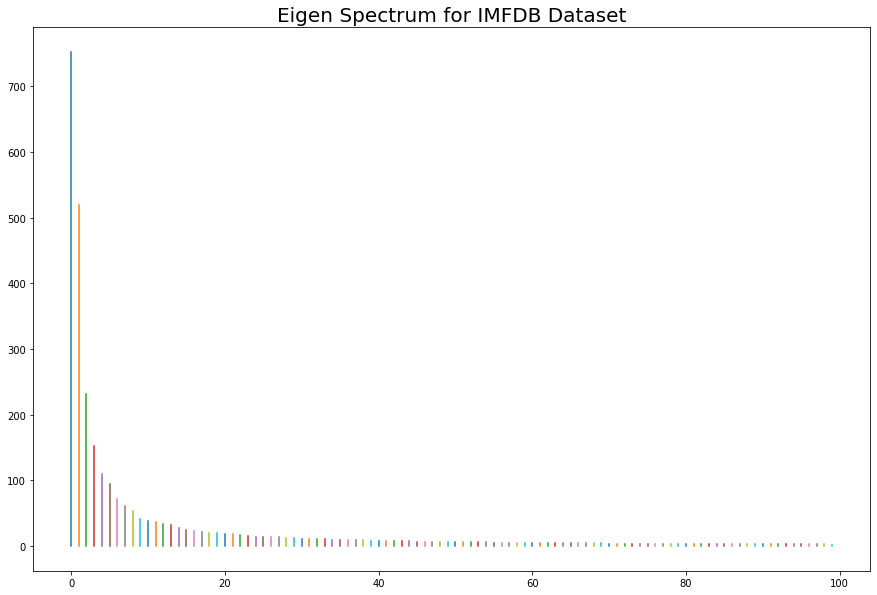

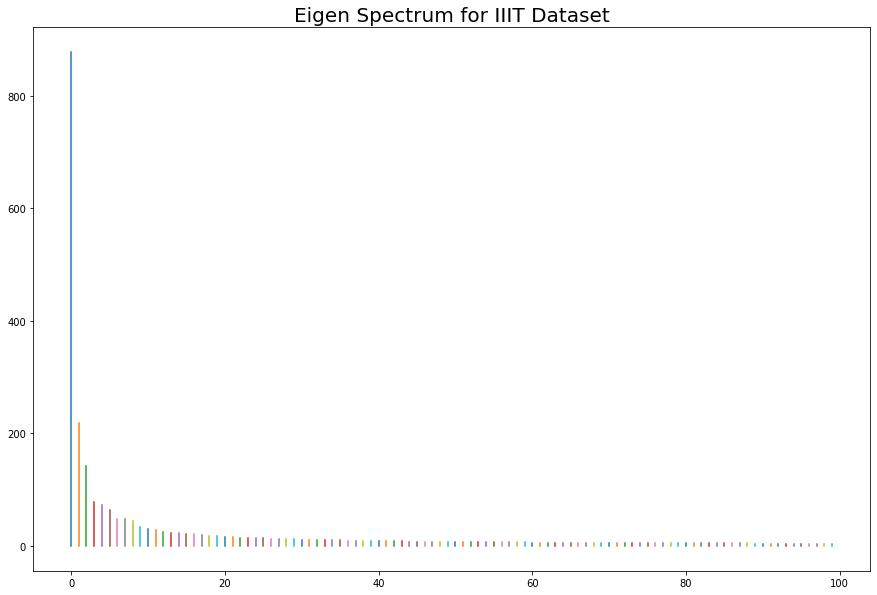

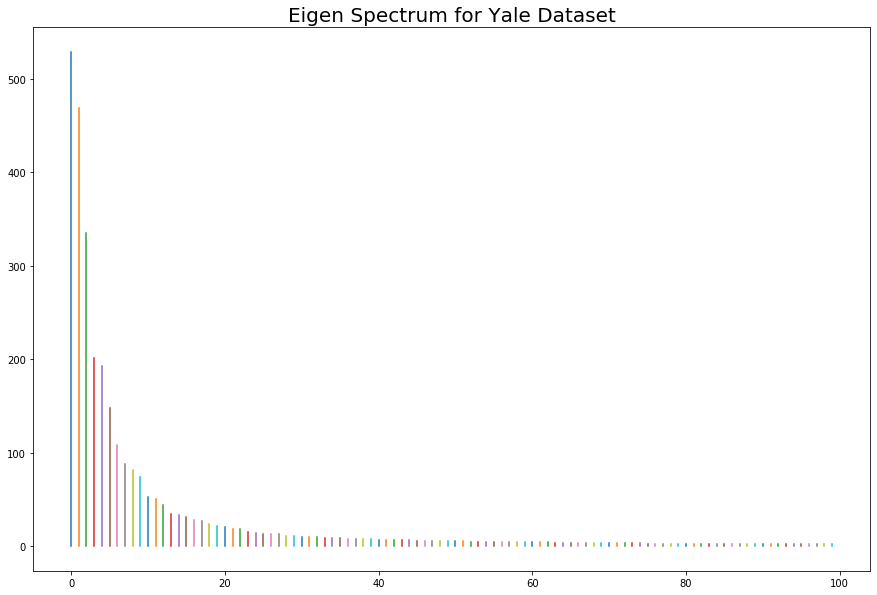

In [17]:
plot_eigen(w_imfdb, 'Eigen Spectrum for IMFDB Dataset')
plot_eigen(w_iiit, 'Eigen Spectrum for IIIT Dataset')
plot_eigen(w_yale, 'Eigen Spectrum for Yale Dataset')

1(c). Reconstruct  the  image  back for each case


In [18]:
def get_reconstructed_img(X, components):
    _, X_reconstructed = get_pca(X, components)
    
    return X_reconstructed

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Reconstructed Images using inverse PCA


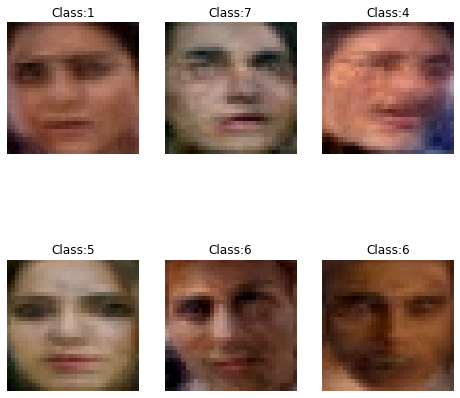

In [19]:
X_reconstructed_imfdb = get_reconstructed_img(X_imfdb, 62)
X_reconstructed_imfdb = X_reconstructed_imfdb.reshape((N_imfdb,H_imfdb,W_imfdb,C_imfdb))

# Display random images
print('Reconstructed Images using inverse PCA')
ind = np.random.randint(0,y.shape[0],6)
disply_images(X_reconstructed_imfdb[ind,...],y[ind],row=2,col=3)

In [20]:
num_component = range(3, 100)

def get_reconstruction_error(X):
    error = []
    
    for i in num_component:
        _, X_reconstructed = get_pca(X, i)
        
        error.append(np.sqrt(np.mean((X - X_reconstructed)**2)))
    
    return error

error_imfdb = get_reconstruction_error(X_imfdb)
error_iiit = get_reconstruction_error(X_iiit)
error_yale = get_reconstruction_error(X_yale)

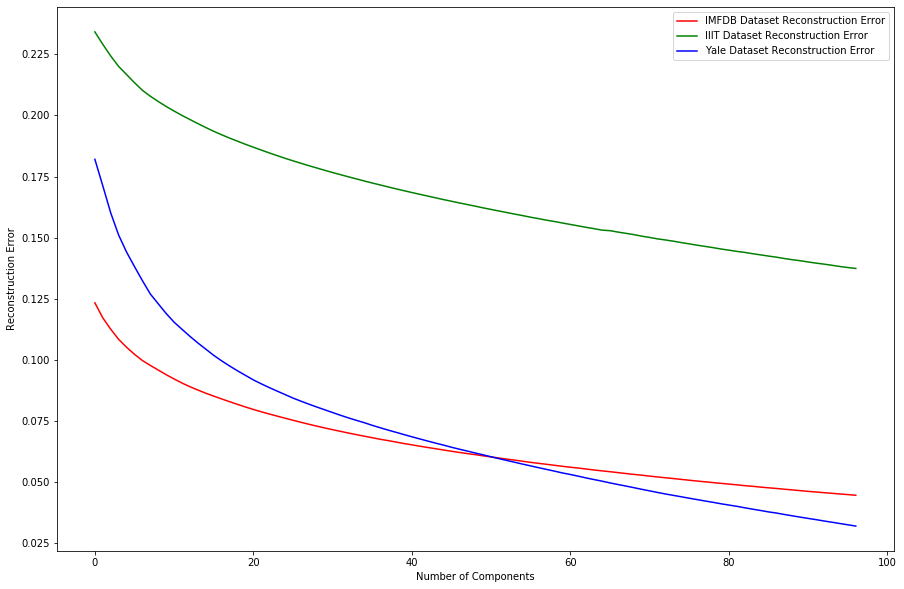

In [21]:
fig = plt.figure(figsize=(15,10))
ax = fig.add_subplot(111)

ax.plot(error_imfdb, c='r', label='IMFDB Dataset Reconstruction Error')
ax.plot(error_iiit, c='g', label='IIIT Dataset Reconstruction Error')
ax.plot(error_yale, c='b', label='Yale Dataset Reconstruction Error')

ax.set_xlabel('Number of Components')
ax.set_ylabel('Reconstruction Error')

plt.legend(loc = 'upper right')
plt.show()

1(d). Which person/identity is difficult to represent com-pactly with fewer eigen vectors?  Why is that?  Explain with your empirical observations and intuitive answers

# Answer
- IIIT dataset is difficult to represent compactly with fewer eigen vectors as can be seen in the above plot. The reconstruction error is the highest in the IIIT Dataset for any number of features. 
- We reconstructed the images in IMFBD Dataset from 10 prinicipal components and calculated the mean reprojection error for all the 8 lables and it is found that images corresponding to label = 7 (Amir) have the highest mean error, so it is difficult to represent Amir's pictures compactly with fewer eigen vectors.

<Figure size 1440x720 with 0 Axes>

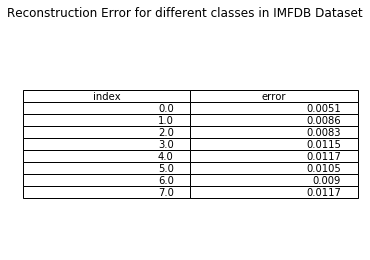

Max Mean Error ->  7


In [22]:
# code goes here
def get_table_plot(df):
    
    plt.figure(figsize=(20,10))
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=df.values, colLabels=df.columns, loc='center', colWidths = [0.5]*len(df.columns))
    
    fig.suptitle('Reconstruction Error for different classes in IMFDB Dataset')
    plt.show()

def get_reconst_error(X, k=10):
    error = []
    
    _, X_reconstructed = get_pca(X, k)
    
    for i in range(len(X)):
        error.append((X[i] - X_reconstructed[i])**2)
    
    return error

reconstruction_error = defaultdict(lambda: [])
reconst_error_10 = get_reconst_error(X_imfdb)

for i in range(N_imfdb):
#     print(i)
    reconstruction_error[y_imfdb[i]].append(reconst_error_10[i])

error_mean = []
for i in range(len(reconstruction_error)):
    error_mean.append(np.mean(reconstruction_error[i]))

table_error = {
    'index' : [],
    'error' : []
}

for i in range(len(error_mean)):
    table_error['index'].append(int(i))
    table_error['error'].append(round(error_mean[i],4))
    
table_error = pd.DataFrame(table_error)

get_table_plot(table_error)

print('Max Mean Error -> ', np.argmax(error_mean))

2(a). Use any classifier(MLP, Logistic regression, SVM, Decision Trees) and find the classification accuracy. 

2(b)Which method works well? Do a comparitivestudy. 


You already know the paper [Face Recognition Us-ing  Kernel  Methods](!http://face-rec.org/algorithms/Kernel/nips01.pdf) .See  this  as  an  example for empirical analysis of different features/classification.

In [23]:
# Define your classifier here. You can use libraries like sklearn to create your classifier 

class Classifier():
    def __init__(self, classifier_type, X_train, y_train, X_test, y_test, feature_num = None, output_classes = None):
#         super.__init__()
        
        self.classifier_type = classifier_type
        self.clf = None
        self.precidtion = None
        
        self.X_train = X_train
        self.y_train = y_train
        
        self.X_test = X_test
        self.y_test = y_test
        
        if self.classifier_type == 'SVM':
            self.clf = SVC(gamma='auto')
            
        if self.classifier_type == 'log_reg':
            self.clf = LogisticRegression(random_state=0, solver='lbfgs', multi_class='multinomial', max_iter=500000)
            
        if self.classifier_type == 'MLP':
            self.clf = MLPClassifier(solver='lbfgs', alpha=1e-5, hidden_layer_sizes=(feature_num, 100, 100, output_classes), random_state=1)
            
    
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self):
        """
            Given an input X classify it into appropriate class. 
        """
        prediction = self.clf.predict(self.X_test)
        self.precidtion = prediction
        
        return prediction
        
    def train(self):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        
        self.clf.fit(self.X_train, self.y_train)
        
    def validate(self):
        """
            How good is the classifier on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters and judge the classification
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your classifier validated. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        try:
            self.squared_error = self.MSE()
        except:
            self.squared_error = None
            
        self.accuracy = self.get_accuracy()
        self.f1_score = f1_score(self.y_test, self.precidtion, average="macro")
        self.precision_score = precision_score(self.y_test, self.precidtion, average="macro")
        self.recall_score = recall_score(self.y_test, self.precidtion, average="macro")
        self.confusion = confusion_matrix(self.y_test, self.precidtion)
        # Create a confusion matrix
        
        # Calculate Validation accuracy 
    
        # Calculate precision and recall 
        
        # Calculate F1-score
    
        return [self.squared_error, self.accuracy, self.f1_score]
    
    def get_r2_score(self):
        return self.clf.score(self.X_test, self.y_test)
    
    def get_confusion_matrix(self):
        return self.confusion
    
    def get_accuracy(self):
        accuracy = (self.precidtion == self.y_test).mean()
        
        return accuracy
    
    def MSE(self):
        return np.sqrt(np.mean((self.precidtion - self.y_test)**2))

In [24]:
# Create a train and validation split to train your classifier 

def split_data(X, y, N, percentage):
    
#     p1 = int(0.8 * N)
    
#     indices = numpy.random.permutation(N)
#     train_idx, test_idx = indices[:p1], indices[p1:p2], indices[p2:]
#     train, validate, test = X[training_idx,:], X[validate_idx,:], X[test_idx,:]
    
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=percentage, random_state=35)
    
    return X_train, X_test, y_train, y_test

In [25]:
def get_predictions(X_train, y_train, X_test, y_test, feature_num, output_classes):
    SVM = Classifier('SVM', X_train, y_train, X_test, y_test)
    SVM.train()
    _ = SVM.classify()

    LogReg = Classifier('log_reg', X_train, y_train, X_test, y_test)
    LogReg.train()
    _ = LogReg.classify()

    MLP = Classifier('MLP', X_train, y_train, X_test, y_test, feature_num, output_classes)
    MLP.train()
    _ = MLP.classify()
    
    return SVM, LogReg, MLP

In [26]:
# PCA Classification for all datasets with 55 features
# Test Set = 20%, Input Features = 55

input_features = 55

X_imfdb_pca, _ = get_pca(X_imfdb, input_features)
X_iiit_pca, _ = get_pca(X_iiit, input_features)
X_yale_pca, _ = get_pca(X_yale, input_features)

X_imfdb_pca_train, X_imfdb_pca_test, y_imfdb_pca_train, y_imfdb_pca_test = split_data(X_imfdb_pca, y_imfdb, N_imfdb, 0.2) 
X_iiit_pca_train, X_iiit_pca_test, y_iiit_pca_train, y_iiit_pca_test = split_data(X_iiit_pca, y_iiit, N_iiit, 0.2)
X_yale_pca_train, X_yale_pca_test, y_yale_pca_train, y_yale_pca_test = split_data(X_yale_pca, y_yale, N_yale, 0.2) 

svm_imfdb_pca, logreg_imfdb_pca, mlp_imfdb_pca = get_predictions(X_imfdb_pca_train, y_imfdb_pca_train, X_imfdb_pca_test, y_imfdb_pca_test, input_features, 8)
svm_iiit_pca, logreg_iiit_pca, mlp_iiit_pca = get_predictions(X_iiit_pca_train, y_iiit_pca_train, X_iiit_pca_test, y_iiit_pca_test, input_features, 8)
svm_yale_pca, logreg_yale_pca, mlp_yale_pca = get_predictions(X_yale_pca_train, y_yale_pca_train, X_yale_pca_test, y_yale_pca_test, input_features, 15)

print(svm_imfdb_pca.validate())
print(logreg_imfdb_pca.validate())
print(mlp_imfdb_pca.validate())

print(svm_iiit_pca.validate())
print(logreg_iiit_pca.validate())
print(mlp_iiit_pca.validate())

print(svm_yale_pca.validate())
print(logreg_yale_pca.validate())
print(mlp_yale_pca.validate())

[1.795828499606797, 0.725, 0.719313055365687]
[1.8874586088176875, 0.7125, 0.7129891880994822]
[2.027929979067325, 0.625, 0.6235273285515579]
[2.156815210409054, 0.4888888888888889, 0.4164360975142223]
[2.1361093050129627, 0.5407407407407407, 0.5030201156778428]
[2.070963275601209, 0.5259259259259259, 0.5016913340282906]
[2.0375267241229382, 0.696969696969697, 0.654875283446712]
[2.3741027013091993, 0.9090909090909091, 0.85]
[3.256694736394648, 0.696969696969697, 0.6564625850340136]


In [27]:
# LDA Classification for all datasets with 30 features
# Test Set = 20%, Input Features = 30

input_features = 30

X_imfdb_lda = get_lda(X_imfdb, y_imfdb, input_features)
X_iiit_lda = get_lda(X_iiit, y_iiit, input_features)
X_yale_lda = get_lda(X_yale, y_yale, input_features)

X_imfdb_lda_train, X_imfdb_lda_test, y_imfdb_lda_train, y_imfdb_lda_test = split_data(X_imfdb_lda, y_imfdb, N_imfdb, 0.2) 
X_iiit_lda_train, X_iiit_lda_test, y_iiit_lda_train, y_iiit_lda_test = split_data(X_iiit_lda, y_iiit, N_iiit, 0.2)
X_yale_lda_train, X_yale_lda_test, y_yale_lda_train, y_yale_lda_test = split_data(X_yale_lda, y_yale, N_yale, 0.2) 

svm_imfdb_lda, logreg_imfdb_lda, mlp_imfdb_lda = get_predictions(X_imfdb_lda_train, y_imfdb_lda_train, X_imfdb_lda_test, y_imfdb_lda_test, input_features, 8)
svm_iiit_lda, logreg_iiit_lda, mlp_iiit_lda = get_predictions(X_iiit_lda_train, y_iiit_lda_train, X_iiit_lda_test, y_iiit_lda_test, input_features, 8)
svm_yale_lda, logreg_yale_lda, mlp_yale_lda = get_predictions(X_yale_lda_train, y_yale_lda_train, X_yale_lda_test, y_yale_lda_test, input_features, 15)

print(svm_imfdb_lda.validate())
print(logreg_imfdb_lda.validate())
print(mlp_imfdb_lda.validate())

print(svm_iiit_lda.validate())
print(logreg_iiit_lda.validate())
print(mlp_iiit_lda.validate())

print(svm_yale_lda.validate())
print(logreg_yale_lda.validate())
print(mlp_yale_lda.validate())

[0.0, 1.0, 1.0]
[0.0, 1.0, 1.0]
[0.0, 1.0, 1.0]
[0.5163977794943222, 0.9703703703703703, 0.9627315513943421]
[0.5773502691896257, 0.9703703703703703, 0.9630975113908347]
[0.8432740427115678, 0.9481481481481482, 0.9408918306575625]
[1.9462473604038075, 0.9393939393939394, 0.9040816326530612]
[0.0, 1.0, 1.0]
[0.0, 1.0, 1.0]


In [28]:
# ResNet Classification
# Test Set = 20%, Input Features = 2048

input_features = 2048

X_imfdb_resnet = get_resnet_features('./dataset/IMFDB')
X_iiit_resnet = get_resnet_features('./dataset/IIIT-CFW')
X_yale_resnet = get_resnet_features('./dataset/Yale_face_database')

# print(X_imfdb_resnet.shape)
# print(X_iiit_resnet.shape)
# print(X_yale_resnet.shape)

X_imfdb_resnet_train, X_imfdb_resnet_test, y_imfdb_resnet_train, y_imfdb_resnet_test = split_data(X_imfdb_resnet, y_imfdb, N_imfdb, 0.2) 
X_iiit_resnet_train, X_iiit_resnet_test, y_iiit_resnet_train, y_iiit_resnet_test = split_data(X_iiit_resnet, y_iiit, N_iiit, 0.2)
X_yale_resnet_train, X_yale_resnet_test, y_yale_resnet_train, y_yale_resnet_test = split_data(X_yale_resnet, y_yale, N_yale, 0.2) 

svm_imfdb_resnet, logreg_imfdb_resnet, mlp_imfdb_resnet = get_predictions(X_imfdb_resnet_train, y_imfdb_resnet_train, X_imfdb_resnet_test, y_imfdb_resnet_test, input_features, 8)
svm_iiit_resnet, logreg_iiit_resnet, mlp_iiit_resnet = get_predictions(X_iiit_resnet_train, y_iiit_resnet_train, X_iiit_resnet_test, y_iiit_resnet_test, input_features, 8)
svm_yale_resnet, logreg_yale_resnet, mlp_yale_resnet = get_predictions(X_yale_resnet_train, y_yale_resnet_train, X_yale_resnet_test, y_yale_resnet_test, input_features, 15)

print(svm_imfdb_resnet.validate())
print(logreg_imfdb_resnet.validate())
print(mlp_imfdb_resnet.validate())

print(svm_iiit_resnet.validate())
print(logreg_iiit_resnet.validate())
print(mlp_iiit_resnet.validate())

print(svm_yale_resnet.validate())
print(logreg_yale_resnet.validate())
print(mlp_yale_resnet.validate())


[0.570087712549569, 0.975, 0.9770792932557639]
[0.6519202405202649, 0.95, 0.9545148810174385]
[0.4183300132670378, 0.9625, 0.9610719513980384]
[0.19245008972987526, 0.9851851851851852, 0.9853866740494648]
[0.17213259316477408, 0.9925925925925926, 0.992911877394636]
[0.4944132324730442, 0.9703703703703703, 0.9717810778136897]
[0.0, 1.0, 1.0]
[0.0, 1.0, 1.0]
[0.0, 1.0, 1.0]


In [29]:
# ResNet Classification with KPCA
# Test Set = 20%, Input Features = 30

input_features = 30

X_imfdb_resnet_kpca = get_kernel_pca(X_imfdb_resnet, 30)
X_iiit_resnet_kpca = get_kernel_pca(X_iiit_resnet, 30)
X_yale_resnet_kpca = get_kernel_pca(X_yale_resnet, 30)



# print(X_imfdb_resnet_kpca.shape)
# print(X_iiit_resnet_kpca.shape)
# print(X_yale_resnet_kpca.shape)

X_imfdb_resnet_kpca_train, X_imfdb_resnet_kpca_test, y_imfdb_resnet_kpca_train, y_imfdb_resnet_kpca_test = split_data(X_imfdb_resnet_kpca, y_imfdb, N_imfdb, 0.2) 
X_iiit_resnet_kpca_train, X_iiit_resnet_kpca_test, y_iiit_resnet_kpca_train, y_iiit_resnet_kpca_test = split_data(X_iiit_resnet_kpca, y_iiit, N_iiit, 0.2)
X_yale_resnet_kpca_train, X_yale_resnet_kpca_test, y_yale_resnet_kpca_train, y_yale_resnet_kpca_test = split_data(X_yale_resnet_kpca, y_yale, N_yale, 0.2) 

svm_imfdb_resnet_kpca, logreg_imfdb_resnet_kpca, mlp_imfdb_resnet_kpca = get_predictions(X_imfdb_resnet_kpca_train, y_imfdb_resnet_kpca_train, X_imfdb_resnet_kpca_test, y_imfdb_resnet_kpca_test, input_features, 8)
svm_iiit_resnet_kpca, logreg_iiit_resnet_kpca, mlp_iiit_resnet_kpca = get_predictions(X_iiit_resnet_kpca_train, y_iiit_resnet_kpca_train, X_iiit_resnet_kpca_test, y_iiit_resnet_kpca_test, input_features, 8)
svm_yale_resnet_kpca, logreg_yale_resnet_kpca, mlp_yale_resnet_kpca = get_predictions(X_yale_resnet_kpca_train, y_yale_resnet_kpca_train, X_yale_resnet_kpca_test, y_yale_resnet_kpca_test, input_features, 15)

print(svm_imfdb_resnet_kpca.validate())
print(logreg_imfdb_resnet_kpca.validate())
print(mlp_imfdb_resnet_kpca.validate())

print(svm_iiit_resnet_kpca.validate())
print(logreg_iiit_resnet_kpca.validate())
print(mlp_iiit_resnet_kpca.validate())

print(svm_yale_resnet_kpca.validate())
print(logreg_yale_resnet_kpca.validate())
print(mlp_yale_resnet_kpca.validate())

[2.4545875417267156, 0.6875, 0.7210013402148953]
[0.7984359711335656, 0.9625, 0.9645337301587302]
[0.8440971508067067, 0.95, 0.9515851711217844]
[0.5900408021045224, 0.9185185185185185, 0.8760589426386389]
[0.19245008972987526, 0.9851851851851852, 0.9853866740494648]
[0.5018484351393873, 0.9629629629629629, 0.9674560429787868]
[4.6839506764476, 0.0, 0.0]
[0.0, 1.0, 1.0]
[1.5374122295716148, 0.8787878787878788, 0.835374149659864]


In [30]:
# VGG + PCA Classification
# Test Set = 20%, Input Features = 55

input_features = 55

X_imfdb_vgg = get_vgg_features('./dataset/IMFDB')
X_iiit_vgg = get_vgg_features('./dataset/IIIT-CFW')
X_yale_vgg = get_vgg_features('./dataset/Yale_face_database')

X_imfdb_vgg, _ = get_pca(X_imfdb_vgg, input_features)
X_iiit_vgg, _ = get_pca(X_iiit_vgg, input_features)
X_yale_vgg, _ = get_pca(X_yale_vgg, input_features)

# print(X_imfdb_vgg.shape)
# print(X_iiit_vgg.shape)
# print(X_yale_vgg.shape)

X_imfdb_vgg_train, X_imfdb_vgg_test, y_imfdb_vgg_train, y_imfdb_vgg_test = split_data(X_imfdb_vgg, y_imfdb, N_imfdb, 0.2) 
X_iiit_vgg_train, X_iiit_vgg_test, y_iiit_vgg_train, y_iiit_vgg_test = split_data(X_iiit_vgg, y_iiit, N_iiit, 0.2)
X_yale_vgg_train, X_yale_vgg_test, y_yale_vgg_train, y_yale_vgg_test = split_data(X_yale_vgg, y_yale, N_yale, 0.2) 

svm_imfdb_vgg, logreg_imfdb_vgg, mlp_imfdb_vgg = get_predictions(X_imfdb_vgg_train, y_imfdb_vgg_train, X_imfdb_vgg_test, y_imfdb_vgg_test, input_features, 8)
svm_iiit_vgg, logreg_iiit_vgg, mlp_iiit_vgg = get_predictions(X_iiit_vgg_train, y_iiit_vgg_train, X_iiit_vgg_test, y_iiit_vgg_test, input_features, 8)
svm_yale_vgg, logreg_yale_vgg, mlp_yale_vgg = get_predictions(X_yale_vgg_train, y_yale_vgg_train, X_yale_vgg_test, y_yale_vgg_test, input_features, 15)

print(svm_imfdb_vgg.validate())
print(logreg_imfdb_vgg.validate())
print(mlp_imfdb_vgg.validate())

print(svm_iiit_vgg.validate())
print(logreg_iiit_vgg.validate())
print(mlp_iiit_vgg.validate())

print(svm_yale_vgg.validate())
print(logreg_yale_vgg.validate())
print(mlp_yale_vgg.validate())

[1.140175425099138, 0.8625, 0.8388941102756893]
[0.7905694150420949, 0.9125, 0.8916600529100529]
[1.161895003862225, 0.8625, 0.8384838374709151]
[1.7554149029450221, 0.6666666666666666, 0.6128142557401423]
[1.9417441567751323, 0.674074074074074, 0.6320569118260757]
[2.1099411963018904, 0.6148148148148148, 0.5645202449619996]
[7.56987650513734, 0.06060606060606061, 0.07111111111111111]
[4.148749355181777, 0.6060606060606061, 0.5315873015873015]
[3.9619401430321606, 0.6060606060606061, 0.5401360544217687]


<Figure size 1440x720 with 0 Axes>

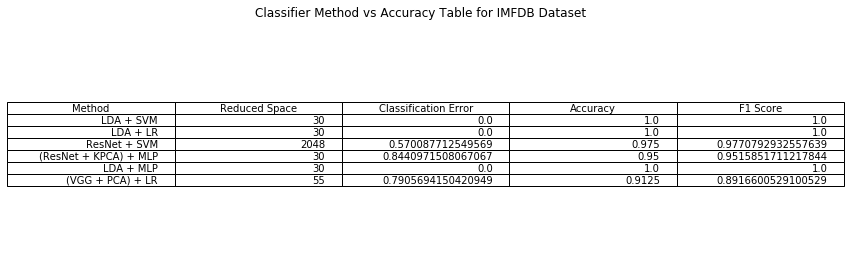

<Figure size 1440x720 with 0 Axes>

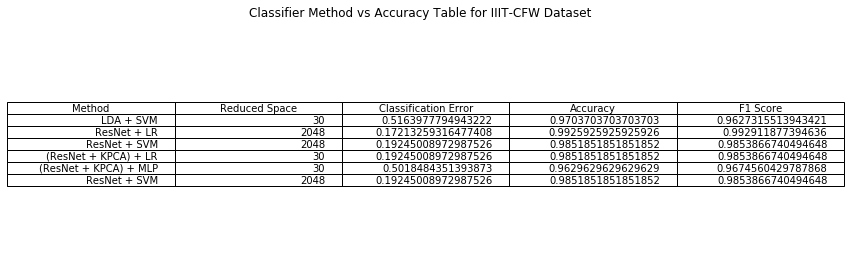

<Figure size 1440x720 with 0 Axes>

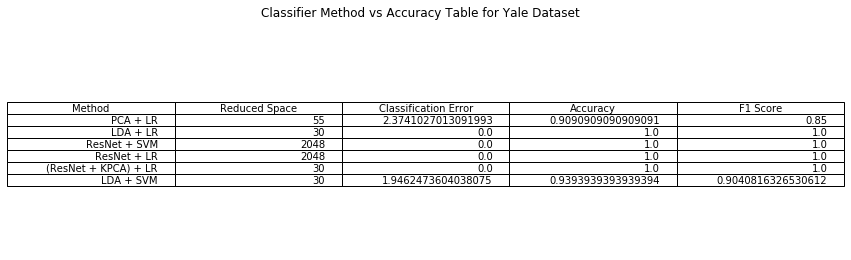

In [31]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, classification error, accuracy, f1-score

# Method	Reduced Space	Classification Error	Accuracy	F1-Score
temp = []
temp.append(svm_imfdb_lda.validate())
temp.append(logreg_imfdb_lda.validate())
temp.append(svm_imfdb_resnet.validate())
temp.append(mlp_imfdb_resnet_kpca.validate())
temp.append(mlp_imfdb_lda.validate())
temp.append(logreg_imfdb_vgg.validate())

imfdb_table = {
    'Method' : ['LDA + SVM', 'LDA + LR', 'ResNet + SVM', '(ResNet + KPCA) + MLP', 'LDA + MLP', '(VGG + PCA) + LR'],
    'Reduced Space' : [30, 30, 2048, 30, 30, 55],
    'Classification Error' : [],
    'Accuracy' : [],
    'F1 Score' : [],
}

for l in temp:
    imfdb_table['Classification Error'].append(l[0])
    imfdb_table['Accuracy'].append(l[1])
    imfdb_table['F1 Score'].append(l[2])
    
temp = []
temp.append(svm_iiit_lda.validate())
temp.append(logreg_iiit_resnet.validate())
temp.append(svm_iiit_resnet.validate())
temp.append(logreg_iiit_resnet_kpca.validate())
temp.append(mlp_iiit_resnet_kpca.validate())
temp.append(svm_iiit_resnet.validate())

iiit_table = {
    'Method' : ['LDA + SVM', 'ResNet + LR', 'ResNet + SVM', '(ResNet + KPCA) + LR', '(ResNet + KPCA) + MLP', 'ResNet + SVM'],
    'Reduced Space' : [30, 2048, 2048, 30, 30, 2048],
    'Classification Error' : [],
    'Accuracy' : [],
    'F1 Score' : [],
}

for l in temp:
    iiit_table['Classification Error'].append(l[0])
    iiit_table['Accuracy'].append(l[1])
    iiit_table['F1 Score'].append(l[2])


temp = []
temp.append(logreg_yale_pca.validate())
temp.append(logreg_yale_lda.validate())
temp.append(svm_yale_resnet.validate())
temp.append(logreg_yale_resnet.validate())
temp.append(logreg_yale_resnet_kpca.validate())
temp.append(svm_yale_lda.validate())

yale_table = {
    'Method' : ['PCA + LR', 'LDA + LR', 'ResNet + SVM', 'ResNet + LR', '(ResNet + KPCA) + LR', 'LDA + SVM'],
    'Reduced Space' : [55, 30, 2048, 2048, 30, 30],
    'Classification Error' : [],
    'Accuracy' : [],
    'F1 Score' : [],
}

for l in temp:
    yale_table['Classification Error'].append(l[0])
    yale_table['Accuracy'].append(l[1])
    yale_table['F1 Score'].append(l[2])
    
imfdb_table = pd.DataFrame(imfdb_table)
iiit_table = pd.DataFrame(iiit_table)
yale_table = pd.DataFrame(yale_table)

# print(imfdb_table)
# print(iiit_table)
# print(yale_table)

# plt.table(cellText=imfdb_table.values,colWidths = [0.25]*len(imfdb_table.columns),
#           rowLabels=imfdb_table.index,
#           colLabels=imfdb_table.columns,
#           cellLoc = 'center', rowLoc = 'center')
def get_table_plot(df, title):
    
    plt.figure(figsize=(20,10))
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=df.values, colLabels=df.columns, loc='center', colWidths = [0.5]*len(df.columns))
    
    fig.suptitle('Classifier Method vs Accuracy Table for ' + title)
    plt.show()

get_table_plot(imfdb_table, 'IMFDB Dataset')
get_table_plot(iiit_table, 'IIIT-CFW Dataset')
get_table_plot(yale_table, 'Yale Dataset')

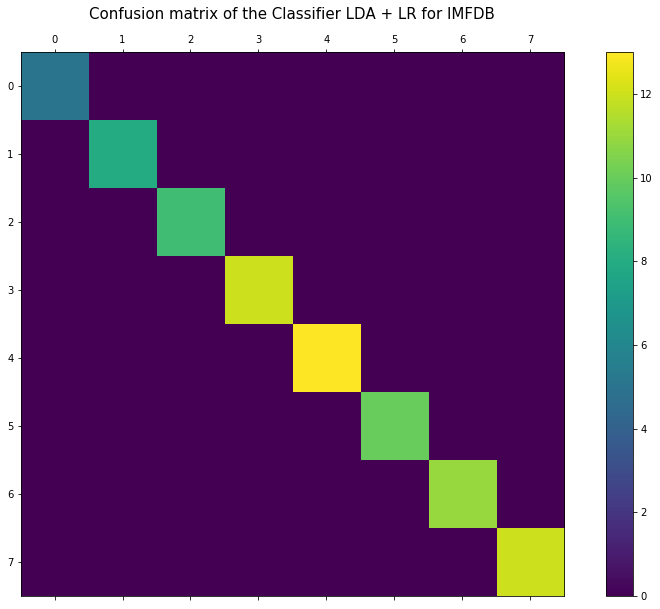

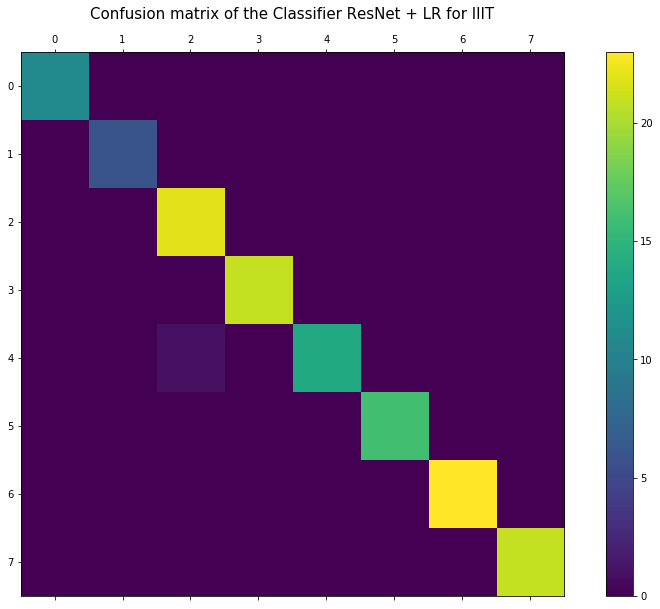

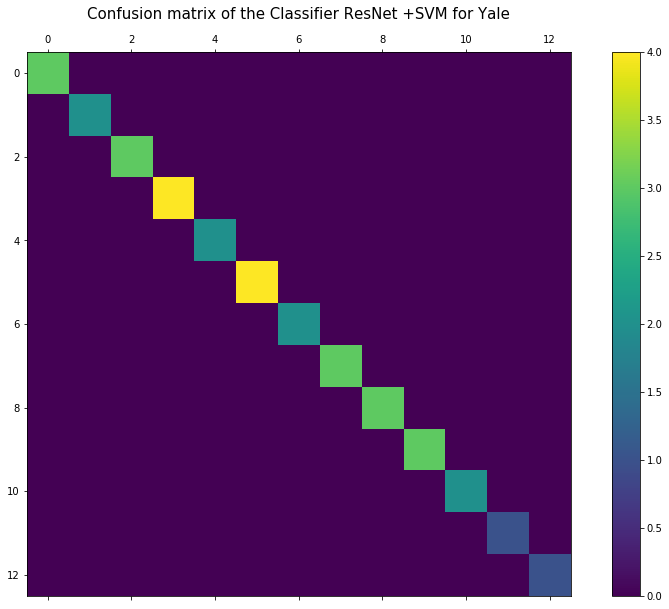

In [32]:
# For each dataset print the confusion matrix for the best model 
def plot_confusion_matrix(model, classifier, dataset):
    cm = model.confusion
    fig = plt.figure(figsize=(15,10))
    ax = fig.add_subplot(111)
    cax = ax.matshow(cm)
    plt.title('Confusion matrix of the Classifier ' + classifier + ' for ' + dataset, fontsize = 15)
    fig.colorbar(cax)
    
plot_confusion_matrix(logreg_imfdb_lda, 'LDA + LR', 'IMFDB')
plot_confusion_matrix(logreg_iiit_resnet, 'ResNet + LR', 'IIIT')
plot_confusion_matrix(svm_yale_resnet, 'ResNet +SVM', 'Yale')

3. Similiar to 1(b) use t-SNE based visilization of faces?  Does it makesense?  Do you see similar people coming together?or something else?  Can you do visualization datasetwise and combined? Here you will use a popular implementation.(Worth  reading and understanding  t-SNE.  We  will not discuss it in the class and out of scope for thiscourse/exams.

In [33]:
dirpath_imfdb = './dataset/IMFDB/'
X_imfdb, y_imfdb, N_imfdb, H_imfdb, W_imfdb, C_imfdb = read_data(dirpath_imfdb)

dirpath_iiit = './dataset/IIIT-CFW/'
X_iiit, y_iiit, N_iiit, H_iiit, W_iiit, C_iiit = read_data(dirpath_iiit)

dirpath_yale = './dataset/Yale_face_database/'
X_yale, y_yale, N_yale, H_yale, W_yale, C_yale = read_data(dirpath_yale)


X_imfdb = X_imfdb.reshape((N_imfdb, H_imfdb * W_imfdb * C_imfdb))
X_iiit = X_iiit.reshape((N_iiit, H_iiit * W_iiit * C_iiit))
X_yale = X_yale.reshape((N_yale, H_yale * W_yale * C_yale))

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


In [34]:
def plot_scatter_tsne(X, y, title, dim):
    
    fig = plt.figure(figsize=(15,10))
    
    if dim == 2:
        ax = fig.add_subplot(111)
        ax.scatter(X[:,0], X[:,1], c=y)
        
    if dim == 3:
        ax = fig.add_subplot(111, projection='3d')
        ax.scatter(X[:,0], X[:,1], X[:,2], c=y)  
        
    ax.set_title(title, fontsize=20)
    
    plt.show()

In [35]:
# Compute TSNE for different features and create a scatter plot for IMFDB Dataset
input_features = 30

X_imfdb_lda = get_lda(X_imfdb, y_imfdb, input_features)
# X_iiit_lda = get_lda(X_iiit, y_iiit, input_features)
# X_yale_lda = get_lda(X_yale, y_yale, input_features)

# print(X_imfdb_lda.shape, X_iiit_lda.shape, X_yale_lda.shape)
X = X_imfdb_lda

# Compute
X_TSNE_2D = TSNE(n_components=2).fit_transform(X)
X_TSNE_3D = TSNE(n_components=3).fit_transform(X)


# Plot the representation in 2d/3d


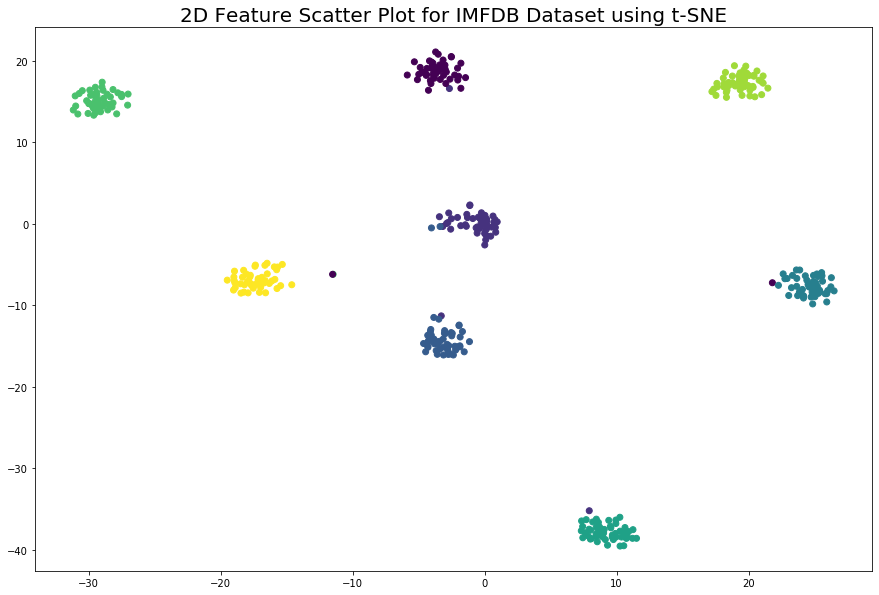

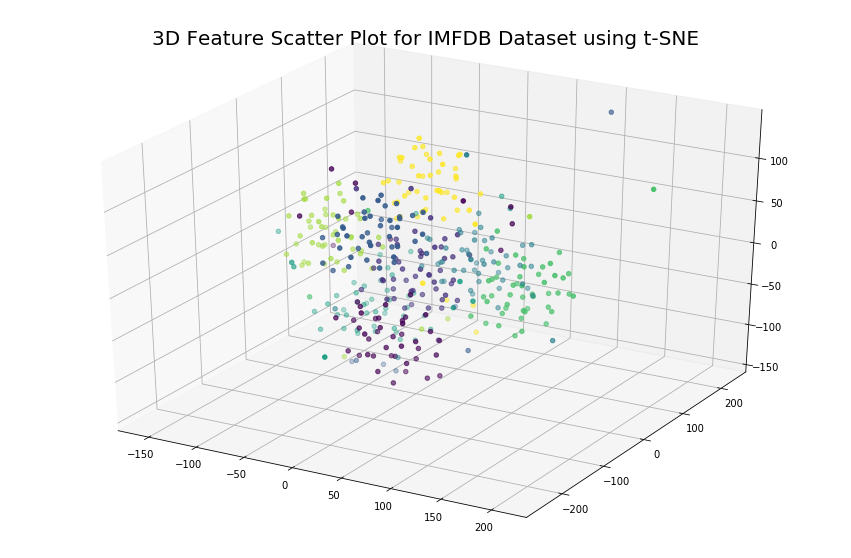

In [36]:
plot_scatter_tsne(X_TSNE_2D, y_imfdb, '2D Feature Scatter Plot for IMFDB Dataset using t-SNE', 2)
plot_scatter_tsne(X_TSNE_3D, y_imfdb, '3D Feature Scatter Plot for IMFDB Dataset using t-SNE', 3)

In [37]:
# print(X_imfdb.shape, X_iiit.shape, X_yale.shape)
# Compute TSNE for different features and create a scatter plot for all Dataset combined

print(X_imfdb_lda.shape, X_iiit_lda.shape, X_yale_lda.shape)

X = np.vstack((X_imfdb, X_iiit))
X = np.vstack((X, X_yale)) 



y_yale_tsne = [] # 0-14
y_iiit_tsne = [] # 15-22
y_imfdb_tsne = [] # 23-30

for i in y_yale:
    y_yale_tsne.append(i)
    
for i in y_iiit:
    y_iiit_tsne.append(i+15)
    
for i in y_imfdb:
    y_imfdb_tsne.append(i+23)
    
# print(y_yale)
y = np.append(y_imfdb_tsne, y_iiit_tsne)
y = np.append(y, y_yale_tsne)

# print(X.shape)

X = get_lda(X, y, 30)
# print(X.shape)

y_color = y * 5

(400, 7) (672, 7) (165, 14)


In [38]:
# Compute
X_TSNE_2D = TSNE(n_components=2).fit_transform(X)
X_TSNE_3D = TSNE(n_components=3).fit_transform(X)

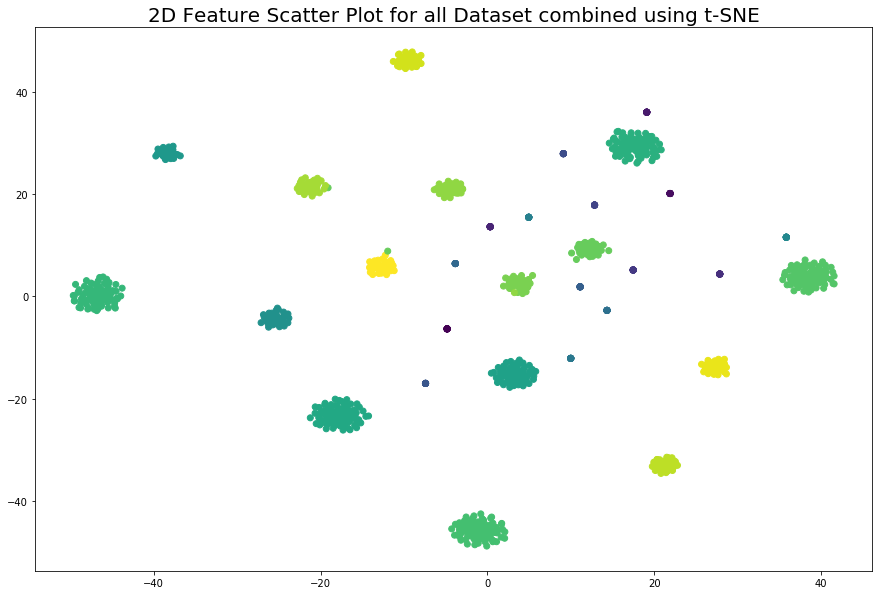

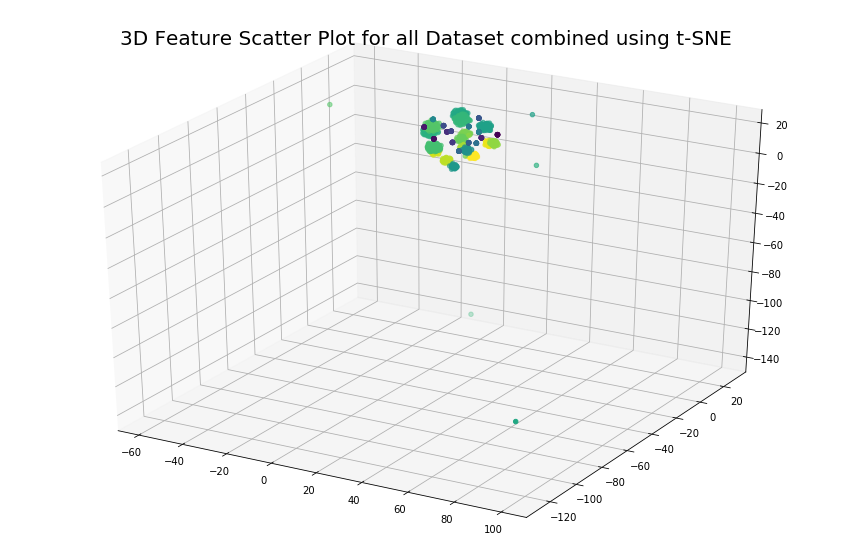

In [39]:
plot_scatter_tsne(X_TSNE_2D, y_color, '2D Feature Scatter Plot for all Dataset combined using t-SNE', 2)
plot_scatter_tsne(X_TSNE_3D, y_color, '3D Feature Scatter Plot for all Dataset combined using t-SNE', 3)

4.`face`  is  used  for  verification.   

4(a) How do we formulate the problem using KNN 

4(b) How do we analyze the performance ? suggest  the  metrics  (like  accuracy) that is appropriate for this task.

_______________________________________________________________________

4(c)Show empirical re-sults  with  all  the  representations

In [40]:
class FaceVerification():
    def __init__(self, X_train, y_train, X_test, y_test, neighbours = 4):
        self.precidtion = None
        
        self.X_train = X_train
        self.y_train = y_train
        
        self.X_test = X_test
        self.y_test = y_test
                
        self.clf = KNeighborsClassifier(n_neighbors=neighbours)
    # Define your parameters eg, W,b, max_iterations etc. 
    
    def classify(self):
        """
            Given an input X find if the class id is correct or not.
            
            @return verfication_results => N vector containing True or False. 
                    If the class-id matches with your prediction then true else false.   
        """
        
        prediction = self.clf.predict(self.X_test)
        self.precidtion = prediction
        
        return prediction
        
    def train(self):
        """
            Given your training data, learn the parameters of your classifier
            
            @param X_train => NxD tensor. Where N is the number of samples and D is the dimension. 
                                it is the data on which your verification system will be trained. 
                                It can be any combination of features provided above.

            @param y_train => N vector. Ground truth label 
    
            @return Nothing
        """
        self.clf.fit(self.X_train, self.y_train)
        
    def validate(self):
        """
            How good is your system on unseen data? Use the function below to calculate different metrics. 
            Based on these matrix change the hyperparmeters
            
            @param X_validate => NxD tensor. Where N is the number of samples and D is the dimension. 
                                It can be any combination of features provided above.

            @param y_validate => N vector. Ground truth label 
            
        """
        try:
            self.squared_error = self.MSE()
        except:
            self.squared_error = None
        self.accuracy = self.get_accuracy()
        self.f1_score = f1_score(self.y_test, self.precidtion, average="macro")
        self.precision_score = precision_score(self.y_test, self.precidtion, average="macro")
        self.recall_score = recall_score(self.y_test, self.precidtion, average="macro")
        self.confusion = confusion_matrix(self.y_test, self.precidtion)
        
        return [self.squared_error, self.accuracy, self.precision_score]
    
    def get_r2_score(self):
        return self.clf.score(self.X_test, self.y_test)
    
    def get_confusion_matrix(self):
        return self.confusion
    
    def get_accuracy(self):
        accuracy = (self.precidtion == self.y_test).mean()
        return accuracy
    
    def MSE(self):
        return np.sqrt(np.mean((self.precidtion - self.y_test)**2))

In [41]:
def get_predictions_knn(X_train, y_train, X_test, y_test, neighbours=4):
    KNN = FaceVerification(X_train, y_train, X_test, y_test, neighbours)
    KNN.train()
    _ = KNN.classify()
    
    return KNN

In [42]:
dirpath_imfdb = './dataset/IMFDB/'
X_imfdb, y_imfdb, N_imfdb, H_imfdb, W_imfdb, C_imfdb = read_data(dirpath_imfdb)

dirpath_iiit = './dataset/IIIT-CFW/'
X_iiit, y_iiit, N_iiit, H_iiit, W_iiit, C_iiit = read_data(dirpath_iiit)

dirpath_yale = './dataset/Yale_face_database/'
X_yale, y_yale, N_yale, H_yale, W_yale, C_yale = read_data(dirpath_yale)


X_imfdb = X_imfdb.reshape((N_imfdb, H_imfdb * W_imfdb * C_imfdb))
X_iiit = X_iiit.reshape((N_iiit, H_iiit * W_iiit * C_iiit))
X_yale = X_yale.reshape((N_yale, H_yale * W_yale * C_yale))

Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)
Dataset shape: (165, 32, 32, 3)


In [43]:
# PCA with KNN
input_features = 55

knn_imfdb_pca = get_predictions_knn(X_imfdb_pca_train, y_imfdb_pca_train, X_imfdb_pca_test, y_imfdb_pca_test)
knn_iiit_pca = get_predictions_knn(X_iiit_pca_train, y_iiit_pca_train, X_iiit_pca_test, y_iiit_pca_test)
knn_yale_pca = get_predictions_knn(X_yale_pca_train, y_yale_pca_train, X_yale_pca_test, y_yale_pca_test)

In [44]:
# LDA with KNN
input_features = 30

knn_imfdb_lda = get_predictions_knn(X_imfdb_lda_train, y_imfdb_lda_train, X_imfdb_lda_test, y_imfdb_lda_test)
knn_iiit_lda = get_predictions_knn(X_iiit_lda_train, y_iiit_lda_train, X_iiit_lda_test, y_iiit_lda_test)
knn_yale_lda = get_predictions_knn(X_yale_lda_train, y_yale_lda_train, X_yale_lda_test, y_yale_lda_test)

In [45]:
# ResNet with KNN

input_features = 2048

knn_imfdb_resnet = get_predictions_knn(X_imfdb_resnet_train, y_imfdb_resnet_train, X_imfdb_resnet_test, y_imfdb_resnet_test)
knn_iiit_resnet = get_predictions_knn(X_iiit_resnet_train, y_iiit_resnet_train, X_iiit_resnet_test, y_iiit_resnet_test)
knn_yale_resnet = get_predictions_knn(X_yale_resnet_train, y_yale_resnet_train, X_yale_resnet_test, y_yale_resnet_test)


In [46]:
# ResNet + KPCA with KNN

input_features = 30

knn_imfdb_resnet_kpca = get_predictions_knn(X_imfdb_resnet_kpca_train, y_imfdb_resnet_kpca_train, X_imfdb_resnet_kpca_test, y_imfdb_resnet_kpca_test)
knn_iiit_resnet_kpca = get_predictions_knn(X_iiit_resnet_kpca_train, y_iiit_resnet_kpca_train, X_iiit_resnet_kpca_test, y_iiit_resnet_kpca_test)
knn_yale_resnet_kpca = get_predictions_knn(X_yale_resnet_kpca_train, y_yale_resnet_kpca_train, X_yale_resnet_kpca_test, y_yale_resnet_kpca_test)

In [47]:
# VGG + PCA with KNN
input_features = 55

knn_imfdb_vgg = get_predictions_knn(X_imfdb_vgg_train, y_imfdb_vgg_train, X_imfdb_vgg_test, y_imfdb_vgg_test)
knn_iiit_vgg = get_predictions_knn(X_iiit_vgg_train, y_iiit_vgg_train, X_iiit_vgg_test, y_iiit_vgg_test)
knn_yale_vgg = get_predictions_knn(X_yale_vgg_train, y_yale_vgg_train, X_yale_vgg_test, y_yale_vgg_test)

In [48]:
temp = []
temp.append(knn_imfdb_pca.validate())
temp.append(knn_imfdb_lda.validate())
temp.append(knn_imfdb_resnet.validate())
temp.append(knn_imfdb_resnet_kpca.validate())
temp.append(knn_imfdb_vgg.validate())

imfdb_table = {
    'Method' : ['PCA + KNN', 'LDA + KNN', 'ResNet + KNN', '(ResNet + KPCA) + KNN', '(VGG + PCA) + KNN'],
    'Reduced Space' : [55, 30, 2048, 30, 55],
    'Classification Error' : [],
    'Accuracy' : [],
    'Precision Score' : [],
}

for l in temp:
    imfdb_table['Classification Error'].append(l[0])
    imfdb_table['Accuracy'].append(l[1])
    imfdb_table['Precision Score'].append(l[2])
    
temp = []
temp.append(knn_iiit_pca.validate())
temp.append(knn_iiit_lda.validate())
temp.append(knn_iiit_resnet.validate())
temp.append(knn_iiit_resnet_kpca.validate())
temp.append(knn_iiit_vgg.validate())

iiit_table = {
    'Method' : ['PCA + KNN', 'LDA + KNN', 'ResNet + KNN', '(ResNet + KPCA) + KNN', '(VGG + PCA) + KNN'],
    'Reduced Space' : [55, 30, 2048, 30, 55],
    'Classification Error' : [],
    'Accuracy' : [],
    'Precision Score' : [],
}

for l in temp:
    iiit_table['Classification Error'].append(l[0])
    iiit_table['Accuracy'].append(l[1])
    iiit_table['Precision Score'].append(l[2])
    
temp = []
temp.append(knn_yale_pca.validate())
temp.append(knn_yale_lda.validate())
temp.append(knn_yale_resnet.validate())
temp.append(knn_yale_resnet_kpca.validate())
temp.append(knn_yale_vgg.validate())

yale_table = {
    'Method' : ['PCA + KNN', 'LDA + KNN', 'ResNet + KNN', '(ResNet + KPCA) + KNN', '(VGG + PCA) + KNN'],
    'Reduced Space' : [55, 30, 2048, 30, 55],
    'Classification Error' : [],
    'Accuracy' : [],
    'Precision Score' : [],
}

for l in temp:
    yale_table['Classification Error'].append(l[0])
    yale_table['Accuracy'].append(l[1])
    yale_table['Precision Score'].append(l[2])

<Figure size 1440x720 with 0 Axes>

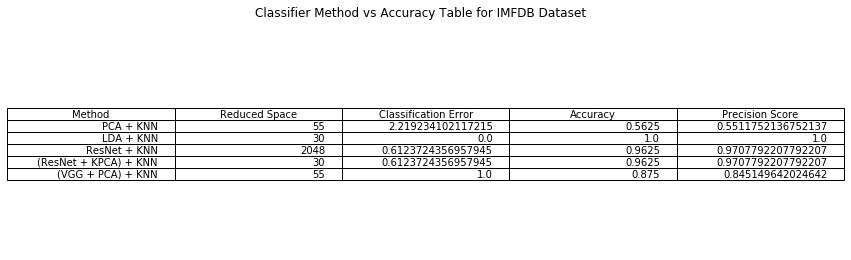

<Figure size 1440x720 with 0 Axes>

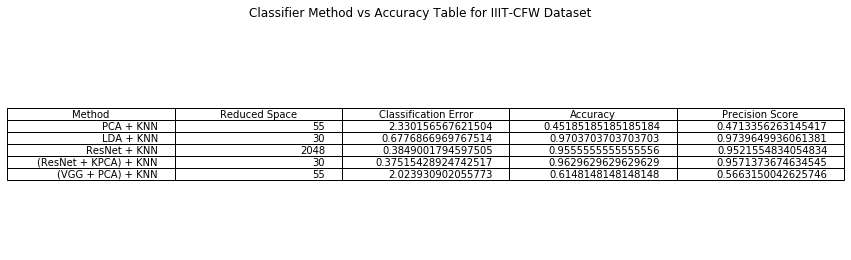

<Figure size 1440x720 with 0 Axes>

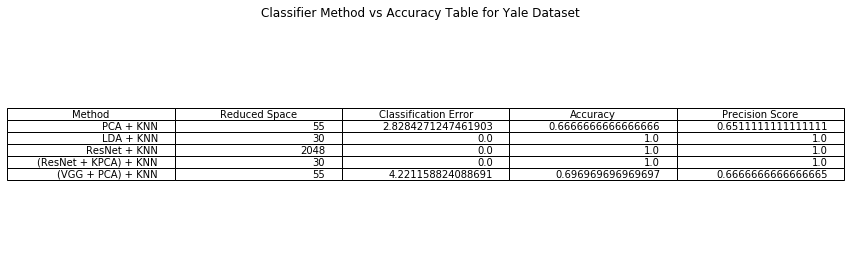

In [49]:
# Create 3 tables simiar to page-6 of the paper. One table per dataset 
# Each table will have 5 columns. 
# Feature/combination of feature used, reduced dimension space, verification error, accuracy, precision

imfdb_table = pd.DataFrame(imfdb_table)
iiit_table = pd.DataFrame(iiit_table)
yale_table = pd.DataFrame(yale_table)

# print(imfdb_table)
# print(iiit_table)
# print(yale_table)

# plt.table(cellText=imfdb_table.values,colWidths = [0.25]*len(imfdb_table.columns),
#           rowLabels=imfdb_table.index,
#           colLabels=imfdb_table.columns,
#           cellLoc = 'center', rowLoc = 'center')
def get_table_plot(df, title):
    
    plt.figure(figsize=(20,10))
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=df.values, colLabels=df.columns, loc='center', colWidths = [0.5]*len(df.columns))
    
    fig.suptitle('Classifier Method vs Accuracy Table for ' + title)
    plt.show()

get_table_plot(imfdb_table, 'IMFDB Dataset')
get_table_plot(iiit_table, 'IIIT-CFW Dataset')
get_table_plot(yale_table, 'Yale Dataset')
# Print the table. (You can use Pandas)

In [50]:
# LDA with KNN
input_features = 30
temp = []

imfdb_table = {
        'Method' : ['LDA + KNN', 'LDA + KNN', 'LDA + KNN', 'LDA + KNN', 'LDA + KNN'],
        'Neighbours' : [],
        'Reduced Space' : [30, 30, 30, 30, 30],
        'Classification Error' : [],
        'Accuracy' : [],
        'Precision Score' : [],
    }

iiit_table = {
        'Method' : ['LDA + KNN', 'LDA + KNN', 'LDA + KNN', 'LDA + KNN', 'LDA + KNN'],
        'Neighbours' : [],
        'Reduced Space' : [30, 30, 30, 30, 30],
        'Classification Error' : [],
        'Accuracy' : [],
        'Precision Score' : [],
    }

yale_table = {
        'Method' : ['LDA + KNN', 'LDA + KNN', 'LDA + KNN', 'LDA + KNN', 'LDA + KNN'],
        'Neighbours' : [],
        'Reduced Space' : [30, 30, 30, 30, 30],
        'Classification Error' : [],
        'Accuracy' : [],
        'Precision Score' : [],
    }

neighbours = [1, 3, 5, 9, 12]
for neighbour in neighbours:
    knn_imfdb_lda = get_predictions_knn(X_imfdb_lda_train, y_imfdb_lda_train, X_imfdb_lda_test, y_imfdb_lda_test, neighbour)
    knn_iiit_lda = get_predictions_knn(X_iiit_lda_train, y_iiit_lda_train, X_iiit_lda_test, y_iiit_lda_test, neighbour)
    knn_yale_lda = get_predictions_knn(X_yale_lda_train, y_yale_lda_train, X_yale_lda_test, y_yale_lda_test, neighbour)
    
    imfdb_predict = knn_imfdb_lda.validate()
    iiit_predict = knn_iiit_lda.validate()
    yale_predict = knn_yale_lda.validate()
    
    imfdb_table['Neighbours'].append(neighbour)
    imfdb_table['Classification Error'].append(imfdb_predict[0])
    imfdb_table['Accuracy'].append(imfdb_predict[1])
    imfdb_table['Precision Score'].append(imfdb_predict[2])
    
    iiit_table['Neighbours'].append(neighbour)
    iiit_table['Classification Error'].append(iiit_predict[0])
    iiit_table['Accuracy'].append(iiit_predict[1])
    iiit_table['Precision Score'].append(iiit_predict[2])    
    
    yale_table['Neighbours'].append(neighbour)
    yale_table['Classification Error'].append(yale_predict[0])
    yale_table['Accuracy'].append(yale_predict[1])
    yale_table['Precision Score'].append(yale_predict[2])
    
    

<Figure size 1440x720 with 0 Axes>

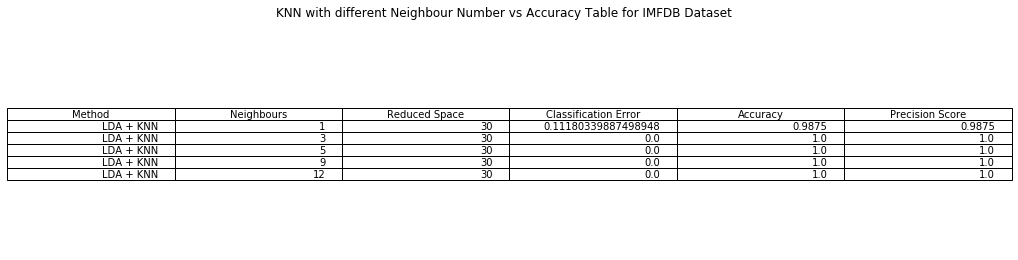

<Figure size 1440x720 with 0 Axes>

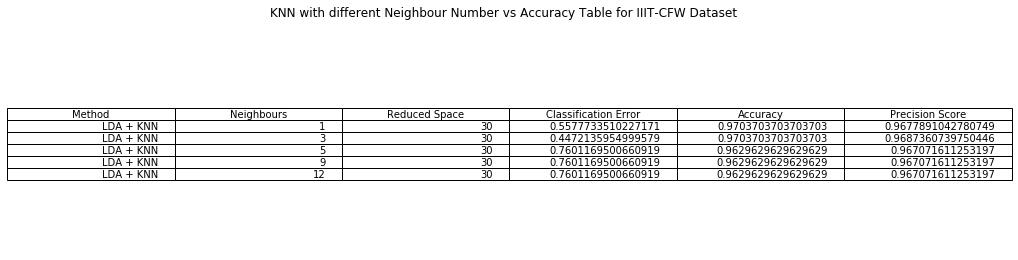

<Figure size 1440x720 with 0 Axes>

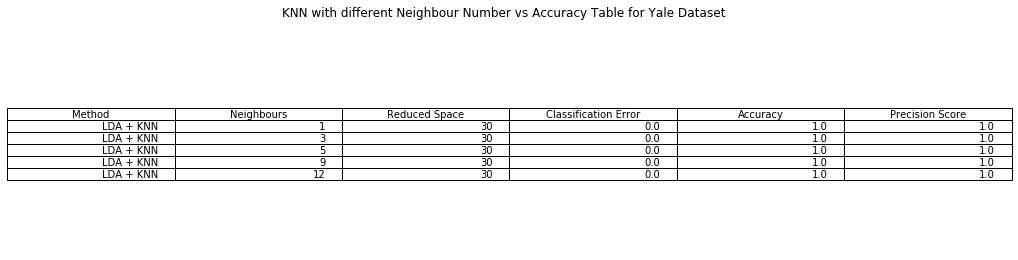

In [51]:
imfdb_table = pd.DataFrame(imfdb_table)
iiit_table = pd.DataFrame(iiit_table)
yale_table = pd.DataFrame(yale_table)

def get_table_plot(df, title):
    
    plt.figure(figsize=(20,10))
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=df.values, colLabels=df.columns, loc='center', colWidths = [0.5]*len(df.columns))
    
    fig.suptitle('KNN with different Neighbour Number vs Accuracy Table for ' + title)
    plt.show()


get_table_plot(imfdb_table, 'IMFDB Dataset')
get_table_plot(iiit_table, 'IIIT-CFW Dataset')
get_table_plot(yale_table, 'Yale Dataset')

### Extenstion / Application
    Create a system for any one of the following problems:

- Politicians  vs  Filmstars  in  a  public  data  set.   (eg.LFW)
        You already have seen IIIT-CFW dataset. Use it for classification. 
- Age prediction
        Given different actors/actress in IMFDB create new labels based on their age.  
- Gender prediction
        Given different actors/actress in IMFDB+IIIT-CFW create new labels based on their gender.
- Emotion classification
        Both the yale dataset and IMFDB contain an `emotion.txt` file. Using that you can create a emotion predicter 
- cartoon vs real images
        Use a combination of IIIT-CFW and other dataset. 
        


You are free to use a new dataset that is publicly avail-able or even create one by crawling from internet.

In [52]:
# Load Image using PIL for dataset
# M = 0
# F = 1

cfw_dict = {'Amitabhbachan': 0,
    'AamirKhan': 0,
    'DwayneJohnson': 0,
    'AishwaryaRai': 1,
    'BarackObama': 0,
    'NarendraModi': 0,
    'ManmohanSingh': 0,
    'VladimirPutin': 0}

imfdb_dict = {'MadhuriDixit': 1,
     'Kajol': 1,
     'SharukhKhan': 0,
     'ShilpaShetty': 1,
     'AmitabhBachan': 0,
     'KatrinaKaif': 1,
     'AkshayKumar': 0,
     'Amir': 0}


def load_image(path):
    im = Image.open(path).convert('L' if opt['is_grayscale'] else 'RGB')
    im = im.resize((opt['image_size'],opt['image_size']))
    im = np.array(im)
    im = im/256
    return im

# Load the full data from directory
def load_data(dir_path):
    image_list = []
    y_list = []
    
    if "CFW" in dir_path:
        label_dict = cfw_dict

    elif "IMFDB" in dir_path:
        label_dict = imfdb_dict
    else:
        raise KeyError("Dataset not found.")
    
    
    for filename in sorted(os.listdir(dir_path)):
        if filename.endswith(".png"):
            im = load_image(os.path.join(dir_path,filename))
            y = filename.split('_')[0]
            y = label_dict[y] 
            image_list.append(im)
            y_list.append(y)
        else:
            continue

    image_list = np.array(image_list)
    y_list = np.array(y_list)

    print("Dataset shape:",image_list.shape)

    return image_list, y_list

def read_data(dirpath):
    X, y = load_data(dirpath)
    N,H,W = X.shape[0:3]
    C = 1 if opt['is_grayscale'] else X.shape[3]
    
    return X, y, N, H, W, C

dirpath_imfdb = './dataset/IMFDB/'
X_imfdb, y_imfdb, N_imfdb, H_imfdb, W_imfdb, C_imfdb = read_data(dirpath_imfdb)

# print(y_imfdb)

dirpath_iiit = './dataset/IIIT-CFW/'
X_iiit, y_iiit, N_iiit, H_iiit, W_iiit, C_iiit = read_data(dirpath_iiit)


X_imfdb = X_imfdb.reshape((N_imfdb, H_imfdb * W_imfdb * C_imfdb))
X_iiit = X_iiit.reshape((N_iiit, H_iiit * W_iiit * C_iiit))
X_original = np.vstack((X_imfdb, X_iiit))



Dataset shape: (400, 32, 32, 3)
Dataset shape: (672, 32, 32, 3)


In [53]:
# Get Features using LDA
features = 50
X_imfdb_lda = get_lda(X_imfdb, y_imfdb, features)
X_iiit_lda = get_lda(X_iiit, y_iiit, features)

X = np.vstack((X_imfdb_resnet, X_iiit_resnet))
y = np.append(y_imfdb, y_iiit)
N = N_imfdb + N_iiit

X_train, X_test, y_train, y_test = split_data(X, y, N, 0.2) 

In [54]:
SVM, LogReg, MLP = get_predictions(X_train, y_train, X_test, y_test, features, 7)
KNN = get_predictions_knn(X_train, y_train, X_test, y_test)
# Validate your classifier
print(SVM.validate())
print(LogReg.validate())
print(MLP.validate())
print(KNN.validate())

[0.11812488464372367, 0.986046511627907, 0.9808497372405807]
[0.1363988678940947, 0.9813953488372092, 0.9752703013572579]
[0.1363988678940947, 0.9813953488372092, 0.9755681818181818]
[0.11812488464372367, 0.986046511627907, 0.984249646059462]


<Figure size 1440x720 with 0 Axes>

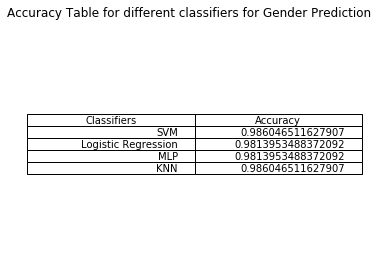

In [55]:
def get_table_plot(df):
    
    plt.figure(figsize=(20,10))
    fig, ax = plt.subplots()
    fig.patch.set_visible(False)
    ax.axis('off')
    ax.axis('tight')

    ax.table(cellText=df.values, colLabels=df.columns, loc='center', colWidths = [0.5]*len(df.columns))
    
    fig.suptitle('Accuracy Table for different classifiers for Gender Prediction')
    plt.show()


table = {
    'Classifiers' : ['SVM', 'Logistic Regression', 'MLP', 'KNN'],
    'Accuracy' : []
}

table['Accuracy'].append(SVM.validate()[1])
table['Accuracy'].append(LogReg.validate()[1])
table['Accuracy'].append(MLP.validate()[1])
table['Accuracy'].append(KNN.validate()[1])

df = pd.DataFrame(table)
get_table_plot(df)


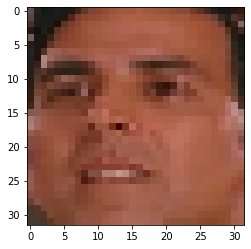

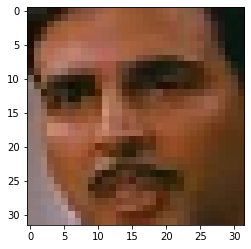

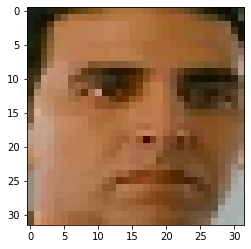

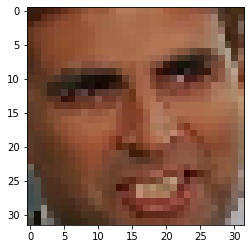

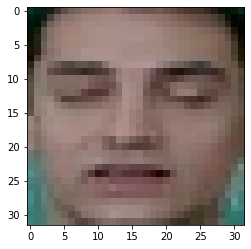

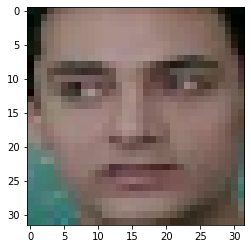

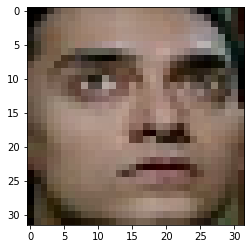

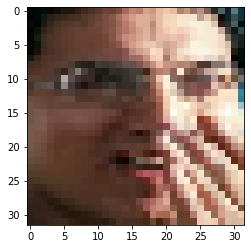

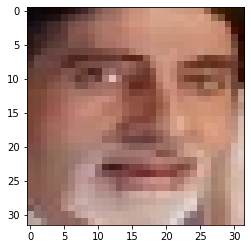

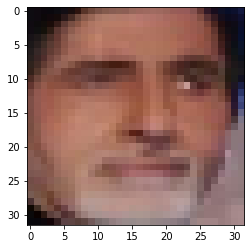

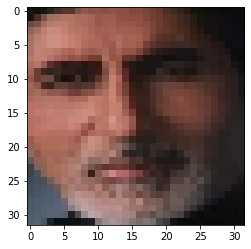

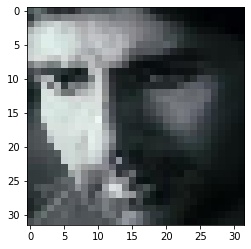

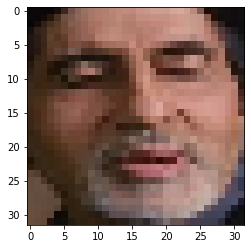

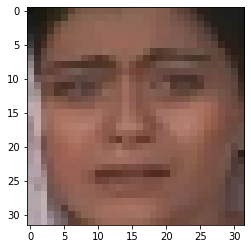

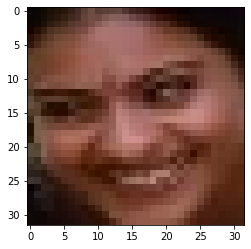

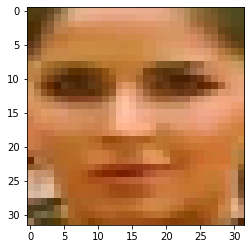

In [56]:
# Correctly Classified Gender
list_choice = range(0, 20)
total_correct_classified = 0
predicted = SVM.classify()

# print(SVM.validate())
# print(predicted)
# print(y)

for i in range(len(predicted)):
    if predicted[i] == y_test[i]:
        random_int = random.choice(list_choice)
        total_correct_classified  += 1
        
        if random_int == 1:
            temp = np.reshape(X_original[i], (H_imfdb, W_imfdb, C_imfdb))
            plt.imshow(temp)
            plt.show()
        
# print(total_correct_classified)

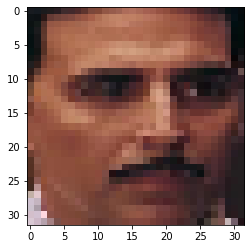

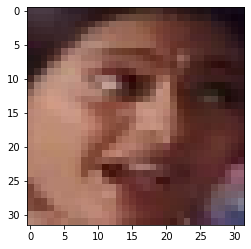

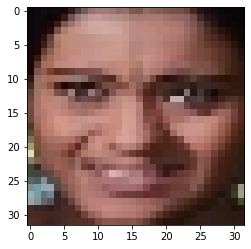

In [57]:
# Misclassified Gender
list_choice = range(1, 2)
total_misclassified = 0
predicted = SVM.classify()

# print(predicted)
# print(y)

for i in range(len(predicted)):
    if predicted[i] != y_test[i]:
        random_int = random.choice(list_choice)
        total_misclassified  += 1
        
        if random_int == 1:
            temp = np.reshape(X_original[i], (H_imfdb, W_imfdb, C_imfdb))
            plt.imshow(temp)
            plt.show()
        
# print(total_misclassified)

In [58]:
kf_accuracy = []
kf_score = []

kf = KFold(n_splits=10, random_state=42, shuffle=False)
for train_index, test_index in kf.split(X):
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]
    KNN = get_predictions_knn(X_train, y_train, X_test, y_test)
    
    
    kf_accuracy.append(KNN.validate()[1])
    kf_score.append(KNN.get_r2_score())

Text(0, 0.5, 'Accuracy')

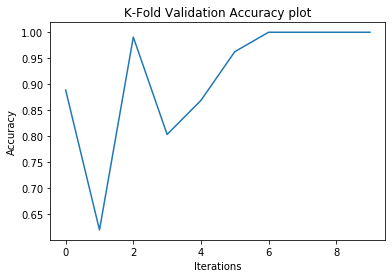

In [59]:
plt.plot(kf_accuracy)
plt.title('K-Fold Validation Accuracy plot')
plt.xlabel('Iterations')
plt.ylabel('Accuracy')